<a href="https://colab.research.google.com/github/seisbench/seisbench_training/blob/main/2023_07_13_obs_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench and the other required dependencies. If all dependencies are already installed on your machine, you can skip this.*

In [ ]:
!pip install pyproj seaborn
!pip install git+https://github.com/seisbench/seisbench
!pip install git+https://github.com/AI4EPS/GaMMA.git

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Deep learning for Ocean Bottom Seismometer data
### Phase picking and catalog generation

This tutorial shows how to use [SeisBench](https://github.com/seisbench/seisbench) with the PickBlue model to detect and associate phases from OBS waveforms. In addition, it explores how to build an earthquake catalog using the detected phases and the [GaMMA associator](https://github.com/AI4EPS/GaMMA).

In the following, we will use data from the [Hikurangi Ocean Bottom Investigation of Tremor and Slow Slip (HOBITSS)](https://fdsn.org/networks/detail/YH_2014/) experiment. This data is new to PickBlue and has not been used for training.

For further details on SeisBench, including an extensive set of tutorials, check out [the repository](https://github.com/seisbench/seisbench) or [the documentation](https://seisbench.readthedocs.org/).

In [1]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pyproj import CRS, Transformer
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from gamma.utils import association
import seisbench.models as sbm

sns.set(font_scale=1.2)
sns.set_style("ticks")

## Picking traces with deep learning

We start by picking phases with deep learning. As a first step, we load the models. To compare the models, we load two of them: PickBlue, a model trained on OBS data and able to harness the hydrophone components in addition to the 3 seismometer components, and a PhaseNet model, trained on land stations.

The models are loaded from the SeisBench repository and afterwards cached locally. They have been pretrained and made available.

**TODO:** Play with different models and see how the predictions change.

In [2]:
pickblue = sbm.PickBlue("phasenet")  # Try "phasenet" and "eqtransformer"
landmodel = sbm.PhaseNet.from_pretrained("original")  # Try out different weights here. How about "original", "ethz" or "instance"? Or maybe even EQTransformer?
# landmodel = sbm.EQTransformer.from_pretrained("original")

Next, we load the waveforms through FDSN. For demonstration purposes, we only use one station and waveforms around known events from [a catalog](https://zenodo.org/record/2022405#.XIbszRNKgWo).

**TODO:** Try out different stations and event times. Or maybe just try a segment without a known event?

In [3]:
client = Client("IRIS")

# Try out different stations - LOBS0 to LOBS9 (some are missing the hydrophone)
station = "LOBS8"

# Try out different events:
# t0 = UTCDateTime(1414618475.7060)
t0 = UTCDateTime(1429618206.7916)
# t0 = UTCDateTime(1404392223.6444)
# t0 = UTCDateTime(1421546179.6840)

stream = client.get_waveforms(network="YH", station=station, location="*", channel="H??", starttime=t0 - 10, endtime=t0 + 60)

stream

4 Trace(s) in Stream:
YH.LOBS8..HDH | 2015-04-21T12:09:56.801200Z - 2015-04-21T12:11:06.791200Z | 100.0 Hz, 7000 samples
YH.LOBS8..HH1 | 2015-04-21T12:09:56.801300Z - 2015-04-21T12:11:06.791305Z | 100.0 Hz, 7000 samples
YH.LOBS8..HH2 | 2015-04-21T12:09:56.801300Z - 2015-04-21T12:11:06.791305Z | 100.0 Hz, 7000 samples
YH.LOBS8..HHZ | 2015-04-21T12:09:56.801300Z - 2015-04-21T12:11:06.791305Z | 100.0 Hz, 7000 samples

Let's apply the PickBlue model to the stream. For this, we use the `annotate` function. It takes an obspy stream and returns phase probability curves. Here, we use `annotate` with a short segment from a single station but you can also pass in multiple stations and long segments. The function will automatically group picks by station, handle data gaps, and take care of all required pre-preprocessing required for the stream.

In [4]:
pickblue.annotate(stream)

3 Trace(s) in Stream:
YH.LOBS8..PhaseNet_P | 2015-04-21T12:09:56.801200Z - 2015-04-21T12:11:06.791200Z | 100.0 Hz, 7000 samples
YH.LOBS8..PhaseNet_S | 2015-04-21T12:09:56.801200Z - 2015-04-21T12:11:06.791200Z | 100.0 Hz, 7000 samples
YH.LOBS8..PhaseNet_N | 2015-04-21T12:09:56.801200Z - 2015-04-21T12:11:06.791200Z | 100.0 Hz, 7000 samples

The below block visualizes the 4C waveforms and the prediction curves. We compare the predictions from PickBlue and the land-based picking model.

**TODO:** Try out different combinations of models, stations and events and see how the two models differ.

Text(0.01, 0.85, 'Land model')

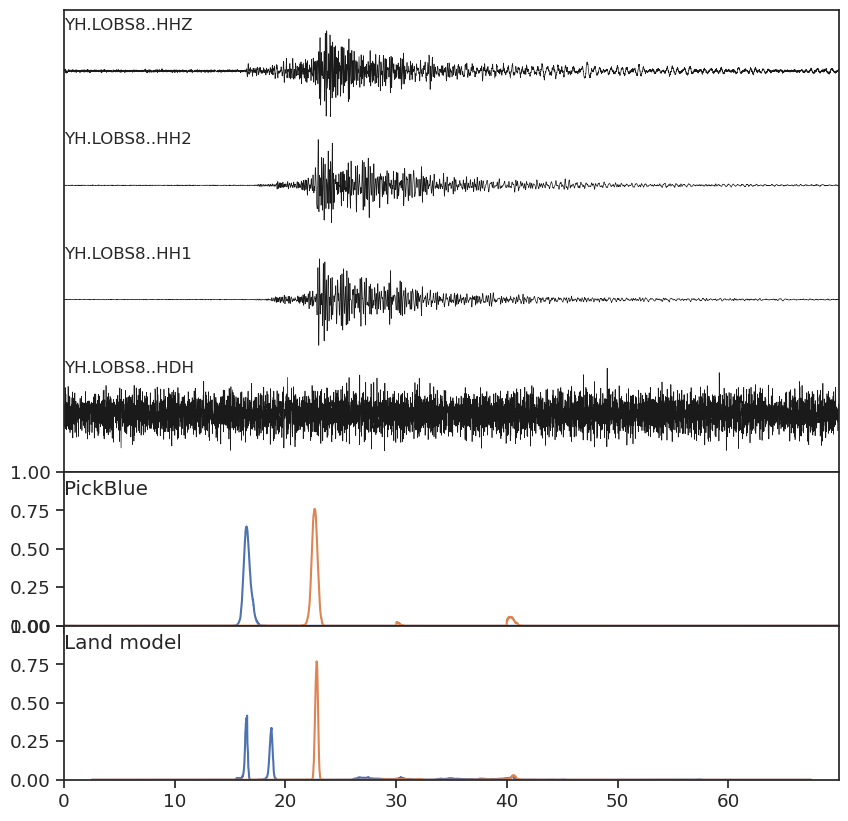

In [5]:
fig = plt.figure(figsize=(10, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1, 1], "hspace": 0})

waveforms = stream.copy().detrend().filter("highpass", freq=2)

for i, trace in enumerate(waveforms):
    normed = trace.data - np.mean(trace.data)
    normed = normed / np.max(np.abs(normed))

    axs[0].text(0, 2.5 * i + 0.9, trace.id, fontsize=12)
    axs[0].plot(trace.times(), 2.5 * i + normed, c="k", lw=0.5)

axs[0].set_yticks([])
axs[0].set_xlim(0, waveforms[0].times()[-1])

def plot_annotations(ann, ax):
    for i, phase in enumerate("PS"):
        trace = ann.select(channel=f"*_{phase}")[0]
        offset = trace.stats.starttime - waveforms[0].stats.starttime
        ax.plot(trace.times() + offset, trace.data)
        ax.set_ylim(0, 1)

plot_annotations(pickblue.annotate(stream), axs[1])
axs[1].text(0.01, 0.85, "PickBlue")
plot_annotations(landmodel.annotate(stream), axs[2])
axs[2].text(0.01, 0.85, "Land model")

While deep learning models usually output phase probability curves, most downstream processing requires phase picks. To bridge these steps, we use a simple triggering algorithm. In SeisBench, you can just use the `classify` function to automatically extract picks from an obspy stream. You can furthermore specify the thresholds, where a pick should be declared.

In [6]:
picks = pickblue.classify(stream, P_threshold=0.1, S_threshold=0.1)
for pick in picks:
    print(pick)

YH.LOBS8.	2015-04-21T12:10:13.291200Z	P
YH.LOBS8.	2015-04-21T12:10:19.441200Z	S


## Building an earthquake catalog

Now that we have seen how to use PickBlue for detecting and picking seismic phase arrivals, we can start building an earthquake catalog. For a short and feasible example, we took four hours of continuous seismic waveforms from the HOBITSS deployment. The same procedure could also be applied to longer-running examples.

For creating an event catalog, in addition to a phase picker, we need a phase associator. Here, we are using the GaMMA associator by Zhu et al (2021). The first codeblock contains all configurations for GaMMa. In addition, we set up a local coordinate projection to measure distances.

In [7]:
# Projections
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(32760)  # UTM zone 60S
transformer = Transformer.from_crs(wgs84, local_crs)

# Gamma
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (580, 720)
config["y(km)"] = (5650, 5770)
config["z(km)"] = (0, 75)
config["vel"] = {"p": 6.7, "s": 6.7 / 1.75}
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 20  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 8
config["max_sigma11"] = 2.5
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

## Obtaining the data

We will use data from the YH network from 25/10/2014 14:00 to 18:00 UTC. To avoid overloading the IRIS FDSN server, we precompiled the dataset and download it directly using wget. For reference, the original download code is contained in the repository.

In [8]:
!wget https://hifis-storage.desy.de:2880/Helmholtz/HelmholtzAI/SeisBench/auxiliary/hobitss_4h.mseed
!wget https://hifis-storage.desy.de:2880/Helmholtz/HelmholtzAI/SeisBench/auxiliary/hobitss_inv.xml

--2023-07-12 15:55:23--  https://hifis-storage.desy.de:2880/Helmholtz/HelmholtzAI/SeisBench/auxiliary/hobitss_4h.mseed
Resolving hifis-storage.desy.de (hifis-storage.desy.de)... 131.169.191.70, 2001:638:700:10bf::1:46
Connecting to hifis-storage.desy.de (hifis-storage.desy.de)|131.169.191.70|:2880... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91516928 (87M) [application/octet-stream]
Saving to: ‘hobitss_4h.mseed’

hobitss_4h.mseed    100%[===================>]  87,28M  24,0MB/s    in 3,8s    

2023-07-12 15:55:27 (23,0 MB/s) - ‘hobitss_4h.mseed’ saved [91516928/91516928]

--2023-07-12 15:55:27--  https://hifis-storage.desy.de:2880/Helmholtz/HelmholtzAI/SeisBench/auxiliary/hobitss_inv.xml
Resolving hifis-storage.desy.de (hifis-storage.desy.de)... 131.169.191.70, 2001:638:700:10bf::1:46
Connecting to hifis-storage.desy.de (hifis-storage.desy.de)|131.169.191.70|:2880... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8686 (8,5K) [application/xml]
S

In [9]:
stream = obspy.read("hobitss_4h.mseed")
inv = obspy.read_inventory("hobitss_inv.xml")

In [10]:
if False:
    client = Client("IRIS")

    channels = "EH?,HH?,HD?"
    
    t0 = UTCDateTime("2014-10-25T14:00:00.000000Z")
    t1 = t0 + 4 * 60 * 60
    stream = client.get_waveforms(network="YH", station="*", location="*", channel=channels, starttime=t0, endtime=t1)

    inv = client.get_stations(network="YH", station="*", location="*", channel=channels, starttime=t0, endtime=t1)
    
    stream.write("data/hobitss_4h.mseed")
    inv.write("data/hobitss_inv.xml", format="STATIONXML")

In [11]:
print(stream.__str__(extended=True))

53 Trace(s) in Stream:
YH.EBS1..EH1  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS1..EH2  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS1..EHZ  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS2..EH1  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS2..EH2  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS2..EHZ  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS3..EH1  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS3..EH2  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS3..EHZ  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18:00:00.000000Z | 200.0 Hz, 2880001 samples
YH.EBS4..EH1  | 2014-10-25T14:00:00.000000Z - 2014-10-25T18

## Picking

First, we need to pick the waveforms using PickBlue. We do this using the `classify` function introduced before.

**Warning:** This will take some time and requires sufficient main memory. If you are short on memory, reduce the study time in the cell before.

**Note:** We automatically check if CUDA is available and run the model on CUDA in this case. Alternatively, the model runs on CPU. If you are running on Google Colab, you can simply select a GPU runtime from 

**TODO:** Try out the impact of different thresholds on the catalog.

In [12]:
picker = sbm.PickBlue()

if torch.cuda.is_available():
    picker.cuda()

# We tuned the thresholds a bit - Feel free to play around with these values
picks = picker.classify(stream, batch_size=256, P_threshold=0.1, S_threshold=0.1)

Counter([p.phase for p in picks])  # Output number of P and S picks

2023-07-12 15:55:28,286 | seisbench | WARNING | You are processing a large stream with the sequential asyncio implementation. Consider activating parallelisation. For details, see http://docs.seisbench.org/en/stable/pages/documentation/models.html#seisbench.models.base.WaveformModel.annotate


Counter({'S': 1674, 'P': 609})

We now convert the picks and station metadata into pandas dataframes in the format required for the GaMMA associator.

In [13]:
pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)

station_df = []
for net in inv:
    for station in net:
        station_df.append({
            "id": f"{net.code}.{station.code}.",
            "longitude": station.longitude,
            "latitude": station.latitude,
            "elevation(m)": station.elevation
        })
station_df = pd.DataFrame(station_df)

station_df["x(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[0] / 1e3, axis=1)
station_df["y(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[1] / 1e3, axis=1)
station_df["z(km)"] = station_df["elevation(m)"] / 1e3

northing = {station: y for station, y in zip(station_df["id"], station_df["y(km)"])}
station_dict = {station: (x, y) for station, x, y in zip(station_df["id"], station_df["x(km)"], station_df["y(km)"])}

Let's have a look at the picks generated by the model. Note that we retained the probability from the deep learning model. It will be used by the associator later on.

In [14]:
pick_df.sort_values("timestamp")

,id,timestamp,prob,type
0,YH.EBS2.,2014-10-25 14:00:06.110000,0.161914,s
1,YH.LOBS9.,2014-10-25 14:00:19.184000,0.116860,s
2,YH.EBS1.,2014-10-25 14:00:22.600000,0.300110,s
3,YH.EBS2.,2014-10-25 14:00:29.450000,0.577072,s
4,YH.LOBS6.,2014-10-25 14:00:33.621000,0.116353,s
...,...,...,...,...
2280,YH.LOBS6.,2014-10-25 17:59:44.401000,0.130010,s
2281,YH.LOBS2.,2014-10-25 17:59:54.435700,0.135102,p
1082,YH.EBS1.,2014-10-25 17:59:56.370000,0.111965,s
1083,YH.EBS2.,2014-10-25 17:59:58.860000,0.411976,s


Let's also check the stations available.

In [15]:
station_df

,id,longitude,latitude,elevation(m),x(km),y(km),z(km)
0,YH.EBS1.,178.678894,-38.745899,-995.0,645.901492,5710.082582,-0.9950
1,YH.EBS2.,178.583496,-38.777100,-930.0,637.550684,5706.767796,-0.9300
2,YH.EBS3.,178.650604,-38.694599,-1023.0,643.545466,5715.820366,-1.0230
3,YH.EBS4.,178.819901,-38.688801,-1712.0,658.282272,5716.184946,-1.7120
4,YH.EBS5.,178.325699,-38.994400,-1348.0,614.805805,5683.009023,-1.3480
5,YH.LOB10.,178.313202,-39.133301,-1444.0,613.500834,5667.609704,-1.4440
6,YH.LOBS1.,178.818695,-38.592098,-993.6,658.390160,5726.918806,-0.9936
7,YH.LOBS2.,179.046097,-38.620998,-3562.5,678.124885,5723.294663,-3.5625
8,YH.LOBS3.,179.147293,-38.792198,-3540.3,686.490000,5704.093102,-3.5403
9,YH.LOBS4.,178.981506,-39.120098,-3440.5,671.298677,5668.026543,-3.4405


## Association

We now run the phase association. This will take a moment. We convert the output into two dataframes, one for the catalog and one for the assignment of picks to the catalog.

In [16]:
catalogs, assignments = association(pick_df, station_df, config, method=config["method"])

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])

Associating 150 clusters with 7 CPUs
......................................................................................................................................................

## Visualizing the catalog

Let's have a look at the catalog.

In [17]:
catalog

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km)
0,2014-10-25T16:05:16.141,999,1.297992,0,0,15.667504,13,5,8,11,650.616004,5707.394857,0.000000
1,2014-10-25T16:05:56.988,999,0.614453,0,0,7.967182,8,1,7,12,641.368436,5688.967165,0.000000
2,2014-10-25T14:57:33.037,999,0.671454,0,0,9.912444,9,0,9,1,592.231908,5665.616811,76.000000
3,2014-10-25T16:49:17.747,999,0.817858,0,0,7.830661,8,3,5,0,664.040015,5698.409255,0.000000
4,2014-10-25T17:52:32.145,999,0.671406,0,0,7.495145,8,1,7,5,639.557970,5710.514426,0.000000
5,2014-10-25T17:52:53.553,999,0.790700,0,0,9.066955,8,2,6,6,656.788922,5692.558290,0.000000
6,2014-10-25T15:29:42.024,999,1.110931,0,0,11.000000,9,2,7,2,627.222514,5697.630160,20.519429
7,2014-10-25T14:59:26.290,999,0.891116,0,0,10.209820,8,3,5,4,628.114430,5670.945611,0.000000
8,2014-10-25T15:43:38.677,999,1.227921,0,0,13.000000,10,3,7,3,642.855136,5699.554565,6.174357
9,2014-10-25T16:35:32.603,999,0.459238,0,0,8.152934,9,1,8,7,660.469508,5730.218680,19.866013


We can also plot the catalog. Conveniently, we are already in a local transverse mercator projection, so need for further thought in the plotting here.

We use the `scatter` function and encode the depth of the events using color. The pattern matches the catalog from https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018JB017211 .

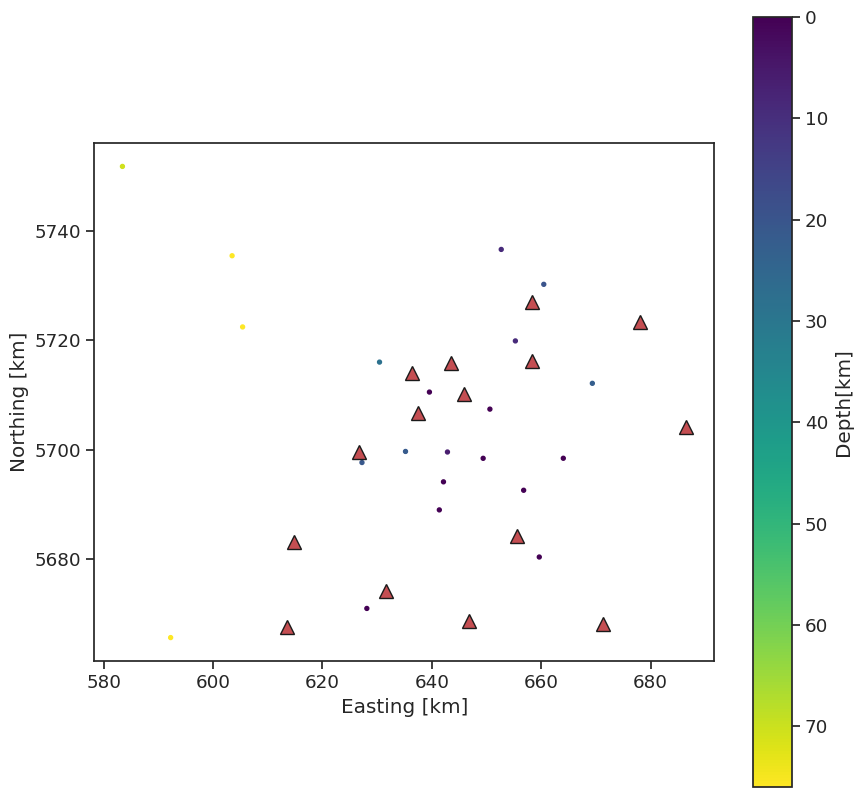

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
cb = ax.scatter(catalog["x(km)"], catalog["y(km)"], c=catalog["z(km)"], s=8, cmap="viridis")
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
cbar.set_label("Depth[km]")

ax.plot(station_df["x(km)"], station_df["y(km)"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.show()

As a last check, we manually inspect some events. The code block below selects a random event and plots the waveforms, together with the P (solid black lines) and S (dashed black lines). The x axis denotes the time, the y axis the hypocental distance between station and estimated event location. Therefore, we should see roughly a linear moveout. Run the cell a few times to see a few example events.

Event information
time            2014-10-25T14:57:33.037
magnitude                           999
sigma_time                     0.671454
sigma_amp                             0
cov_time_amp                          0
gamma_score                    9.912444
num_picks                             9
num_p_picks                           0
num_s_picks                           9
event_index                           1
x(km)                        592.231908
y(km)                       5665.616811
z(km)                              76.0
Name: 2, dtype: object


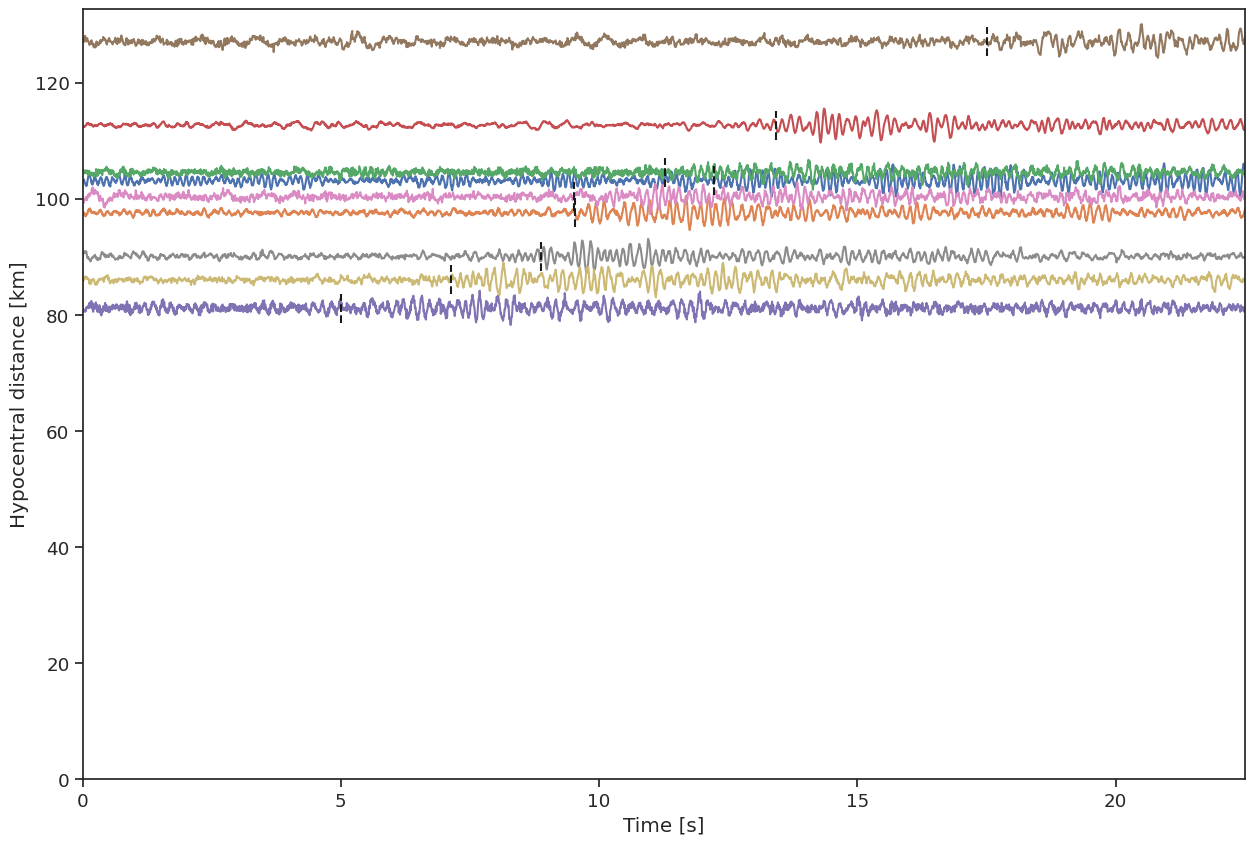

In [21]:
event_idx = np.random.choice(catalog["event_index"])
event_picks = [picks[i] for i in assignments[assignments["event_idx"] == event_idx]["pick_idx"]]
event = catalog[catalog["event_index"] == event_idx].iloc[0]

first, last = min(pick.peak_time for pick in event_picks), max(pick.peak_time for pick in event_picks)

sub = obspy.Stream()

for station in np.unique([pick.trace_id for pick in event_picks]):
    sub.append(stream.select(station=station[3:-1], channel="??1")[0])

sub = sub.slice(first - 5, last + 5)

sub = sub.copy()
sub.detrend()
sub.filter("highpass", freq=2)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

for i, trace in enumerate(sub):
    normed = trace.data - np.mean(trace.data)
    normed = normed / np.max(np.abs(normed))
    station_x, station_y = station_dict[trace.id[:-4]]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    ax.plot(trace.times(), 3 * normed + y)

for pick in event_picks:
    station_x, station_y = station_dict[pick.trace_id]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    x = pick.peak_time - trace.stats.starttime
    if pick.phase == "P":
        ls = '-'
    else:
        ls = '--'
    ax.plot([x, x], [y - 2.5, y + 2.5], 'k', ls=ls)

ax.set_ylim(0)
ax.set_xlim(0, np.max(trace.times()))
ax.set_ylabel("Hypocentral distance [km]")
ax.set_xlabel("Time [s]")

print("Event information")
print(event)

## Closing remarks

In this tutorial, we saw how to quickly generate an event catalog from raw seismic waveforms and their metadata using SeisBench and the GaMMA associator.

- We used a local coordinate projection for New Zealand for this tutorial. Depending on the region, you will need to choose a different projection.
- Both the picker and the model have several tuning parameters. We tuned these parameters loosely, but we would like to make the reader aware that these parameters can have strong influence on the number of picks and events, the number of false positives, and the runtime performance of the associator.
- While GaMMA outputs locations, these are only preliminary. In particular, there tend to be incorrectly located shallow detections. It is highly recommended to further improve these using a more advances tool for localization, e.g., NonLinLoc.

This concludes our tutorial for PickBlue and SeisBench. To find out more about SeisBench, for example, how to compile datasets or train your own models, check out the repository at (https://github.com/seisbench/seisbench).